# Extend dataset using other splitters and embedders

I think that approach I have used to find relevant pictures for the dataset might have backfired: it is practically overfit to the results which are found with Instructor embeddings and 120-60 splitter. I would like to try other configurations to avoid bias

In [1]:
%load_ext dotenv
%dotenv

In [2]:
from pathlib import Path
from portrait_search.dependencies import Container
from portrait_search.embeddings.embedders import EMBEDDERS, EmbedderType
from portrait_search.embeddings.splitters import SPLITTERS, SplitterType

container = Container()
container.init_resources()

SPLITTER = SplitterType.LANGCHAIN_RECURSIVE_TEXT_SPLITTER_CHUNK_160_OVERLAP_40
EMBEDDER = EmbedderType.INSTRUCTOR_LARGE_PATHFINDER_CHARACTER_INSTRUCTIONS

container.splitter.override(SPLITTERS[SPLITTER])
container.embedder.override(EMBEDDERS[EMBEDDER])

retriever = container.retriever()
retriever.splitter, retriever.embedder

/home/tsdaemon/.cache/pypoetry/virtualenvs/portrait-search-PDxvISEv-py3.11/lib/python3.11/site-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512


(LangChainRecursiveSplitter({'splitter': <langchain.text_splitter.RecursiveCharacterTextSplitter object at 0x7f8c0c3d4e50>, '_type': <SplitterType.LANGCHAIN_RECURSIVE_TEXT_SPLITTER_CHUNK_160_OVERLAP_40: 'langchain-recursive-text-splitter-chunk-160-overlap-40'>}),
 InstructorEmbedder({'expected_dimensionality': None, '_type': <EmbedderType.INSTRUCTOR_LARGE_PATHFINDER_CHARACTER_INSTRUCTIONS: 'instrtucor-large-pathfinder-character-instructions'>, 'instructions': 'Represents a description of a Pathfinder character:', 'model': INSTRUCTOR(
   (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: T5EncoderModel 
   (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
   (2): Dense({'in_features': 1024, 'out_features': 768, 'bias': False, 'activa

In [3]:
portraits_path = Path().absolute().parent / ".data/portraits"
portraits_path.exists()

True

Besides, manually editing config is quite boring and leads to errors. I want to make it interactive:
1. Load dataset
2. For each query, run it and get results
3. For each result, ask if it matches the query and ask to select the list of matches
4. After editing one query, validate and store results

In [4]:
from portrait_search.quality.dataset import load_dataset, store_dataset, validate_dataset, Query, PortraitMatch
from IPython import display

dataset = load_dataset("v1")
dataset

[Dataset entry: tanky. Queries: 4. Portraits: 27.,
 Dataset entry: inquisitor-hammer. Queries: 4. Portraits: 24.,
 Dataset entry: dreamy-woman. Queries: 4. Portraits: 14.,
 Dataset entry: human-druid-cleric. Queries: 4. Portraits: 21.,
 Dataset entry: man-portrait. Queries: 4. Portraits: 14.,
 Dataset entry: gnome-rogue. Queries: 3. Portraits: 15.,
 Dataset entry: red-cape-assasin. Queries: 4. Portraits: 19.,
 Dataset entry: elf-fire-blades. Queries: 3. Portraits: 14.,
 Dataset entry: brutal-warrior. Queries: 5. Portraits: 17.,
 Dataset entry: org-twohanded-rogue. Queries: 4. Portraits: 15.]

In [5]:
# Try storing it to see if it preserves formatting
store_dataset(dataset, "v1")

In [30]:
from copy import copy


async def check_query(query: Query):
    # First check exising portraits
    existing_portrait = copy(query.portraits)
    for existing_portrait in existing_portrait:
        display.display(display.Image(filename=portraits_path / existing_portrait.path, height=350, width=350), clear=True, display_id="1")
        matches_list = "".join([f" * {m}\n" for m in existing_portrait.match])
        display.display(
            display.Pretty(f"Portrait {existing_portrait.path} already exists in query with matches:\n{matches_list}Is it correct? (y/n)"), 
            display_id="1"
        )
        match_correct_answer = input()
        display.display(display.Pretty(f"Answer: {match_correct_answer}"), display_id="1")
        match_incorrect = match_correct_answer == "n"
        if not match_incorrect:
            continue
        # remove portrait from query and add it again
        display.display(display.Pretty(f"Removing {existing_portrait}"), display_id="1")
        query.portraits.remove(existing_portrait)

        new_matches: set[str] = set()
        for match in query.match:
            display.display(display.Pretty(f"Is this portrait matches \"{match}\"? (y/n)"), display_id="1")
            match_confirmed_answer = input()
            display.display(display.Pretty(f"Answer: {match_confirmed_answer}"), display_id="1")
            match_confirmed = match_confirmed_answer == "y"
            if match_confirmed:
                new_matches.add(match)
        if new_matches:
            query.portraits.append(PortraitMatch(path=existing_portrait.path, match=new_matches))

        validate_dataset(dataset, portraits_path)
        store_dataset(dataset, "v1")
    
    # Then check new potential portraits
    portraits, explanations = await retriever.get_portraits(query.query, experiment="v1")

    for portrait, explanation in zip(portraits, explanations):
        display.display(display.Pretty(data=portrait.fulllength_path), display_id="1", clear=True)
        display.display(display.Image(filename=portraits_path / portrait.fulllength_path, height=350, width=350), display_id="1")
        display.display(*[display.Pretty(data=e.to_explanation()) for e in explanation], display_id="1")

        existing_portrait = next((p for p in query.portraits if p.path == portrait.fulllength_path), None)
        if existing_portrait is not None:
            continue
        
        new_matches: set[str] = set()
        for match in query.match:
            display.display(display.Pretty(f"Is this portrait matches \"{match}\"? (y/n)"), display_id="1")
            match_confirmed_answer = input()
            display.display(display.Pretty(f"Answer: {match_confirmed_answer}"), display_id="1")
            match_confirmed = match_confirmed_answer == "y"
            if match_confirmed:
                new_matches.add(match)
        
        if len(new_matches) > 0:
            query.portraits.append(PortraitMatch(path=portrait.fulllength_path, match=new_matches))
        
        validate_dataset(dataset, portraits_path)
        store_dataset(dataset, "v1")

# Tanky

In [18]:
dataset_entry = dataset[0]
dataset_entry

Dataset entry: tanky. Queries: 4. Portraits: 51.

In [14]:
query = dataset_entry.queries[3]
query

Query: "closed helmet knight with a halberd". Query matches: "halberd, knight, closed helmet". Portraits: 4.

nexusmods-pathfinderkingmaker-92-974/HE (Human, Elf, Half-Elf)/HE_Melee, Fighter/Shield (Stalwart Defender, Tower Shield Specialist)/HE-MF-SH-M202/Fulllength.png

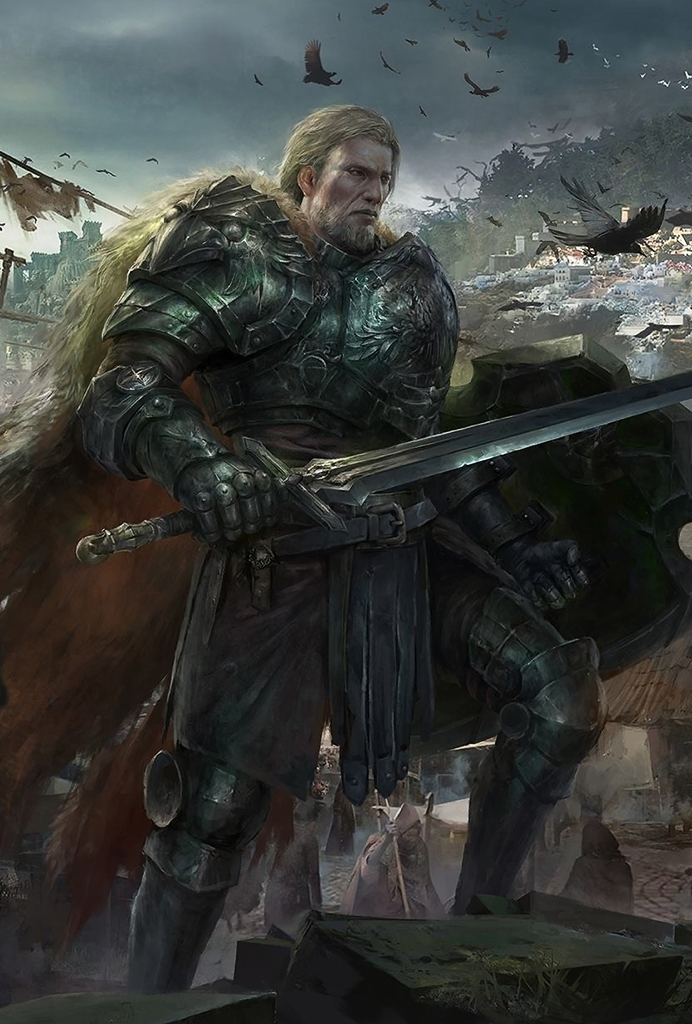

Query: closed helmet knight with a halberd
Portrait text: or a paladin, given his heavy plate armor and the greatsword he's holding—both indicative of a character ready for melee combat. The armor he wears is of a
Similarity: 0.11005717515945435

Is this portrait matches "halberd"? (y/n)

Answer: n

Is this portrait matches "knight"? (y/n)

Answer: y

Is this portrait matches "closed helmet"? (y/n)

Answer: n

In [15]:
await check_query(query)

In [19]:
dataset_entry

Dataset entry: tanky. Queries: 4. Portraits: 51.

# Inquisitor with a hammer

In [22]:
dataset_entry = dataset[1]
dataset_entry

Dataset entry: inquisitor-hammer. Queries: 4. Portraits: 24.

In [29]:
query = dataset_entry.queries[3]
query

Query: "necromancer in heavy armor with two-handed weapon". Query matches: "necromancer, two-handed weapon, heavy armor". Portraits: 6.

nexusmods-pathfinderkingmaker-92-974/MX (Mixed) Misc/MX_Misc_Crafter, Misc, No Background/No Background/MX-MS-NB-M207/Fulllength.png

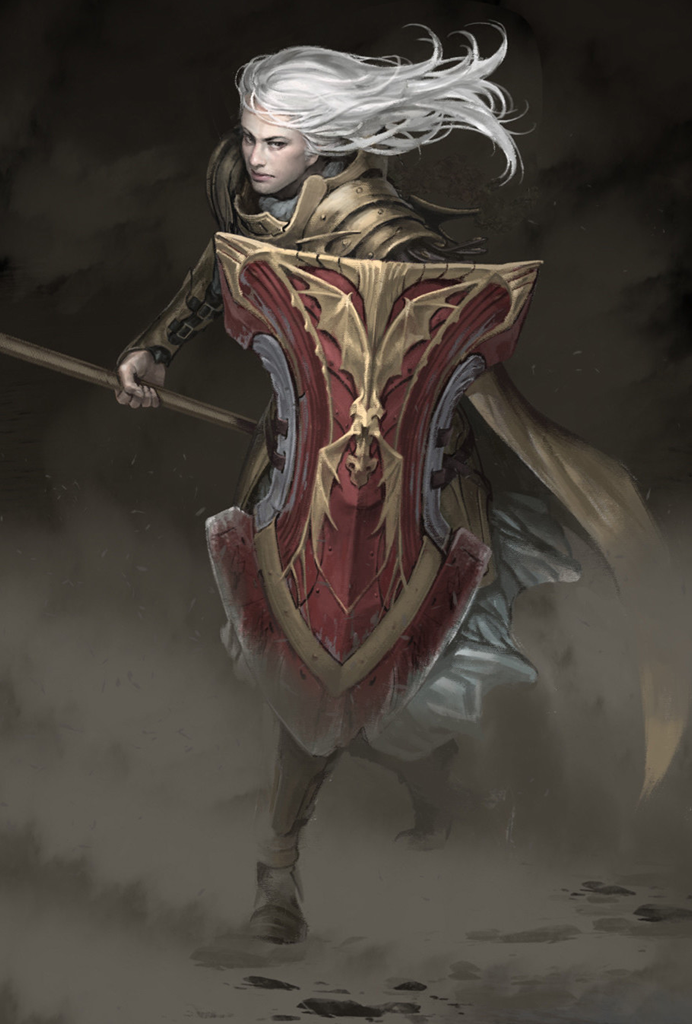

Query: necromancer in heavy armor with two-handed weapon
Portrait text: The character appears to be in armor that suggests a heavily armored class with martial capabilities, likely classes such as a paladin or a fighter. The large,
Similarity: 0.11005640029907227

Is this portrait matches "necromancer"? (y/n)

Answer: n

Is this portrait matches "two-handed weapon"? (y/n)

Answer: n

Is this portrait matches "heavy armor"? (y/n)

Answer: y

In [31]:
await check_query(query)